1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Consolidated Metrics:
Mean General MSE: 0.05286425948143005
Mean General R²: 0.9475449919700623
Mean General Adjusted R²: 0.9460851117081924
--- GDP growth Metrics ---
Mean MSE: 0.06514371522456186
Mean RMSE: 0.2546810089022219
Mean R²: 0.9352291356947754
Mean Adjusted R²: 0.9334264916786029
--- Inflation Metrics ---
Mean MSE: 0.06051884042653897
Mean RMSE: 0.24033450897433256
Mean R²: 0.9385550790837129
Mean Adjusted R²: 0.936844999710803
--- Gini index Metrics ---
Mean MSE: 0.03293020661241429
Mean RMSE: 0.18078371094634363
Mean R²: 0.9688507230576201
Mean Adjusted R²: 0.9679838046014503


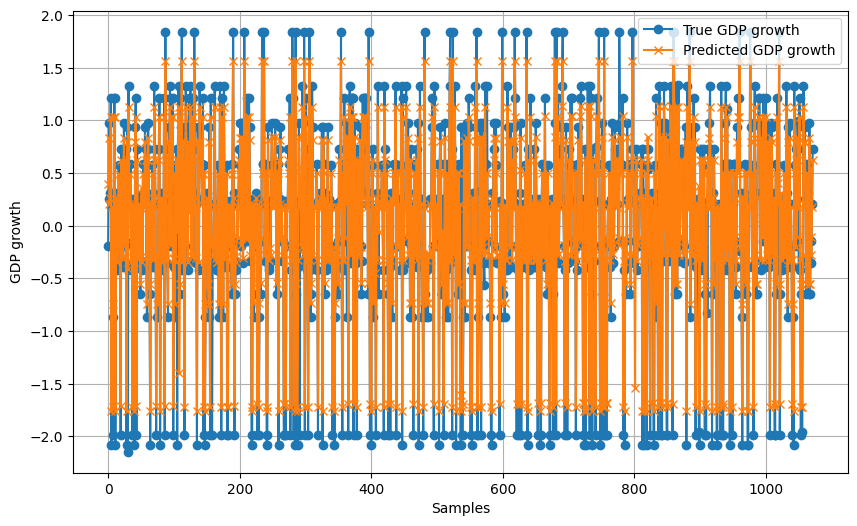

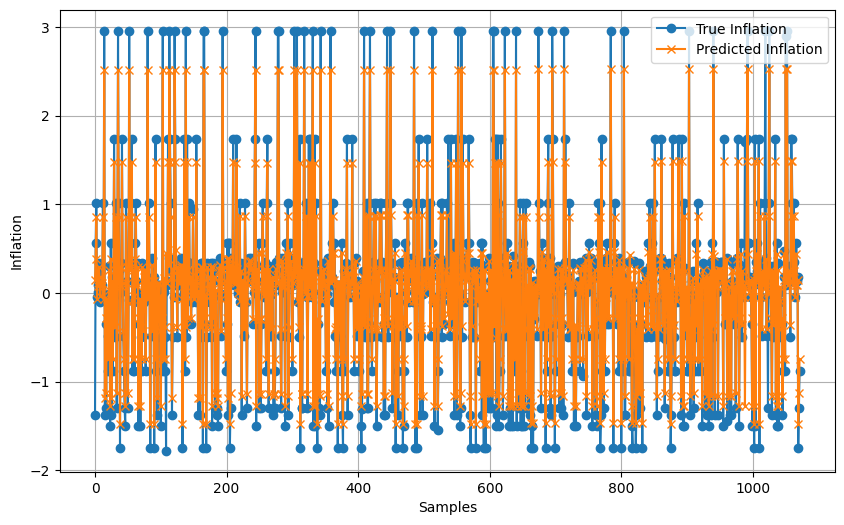

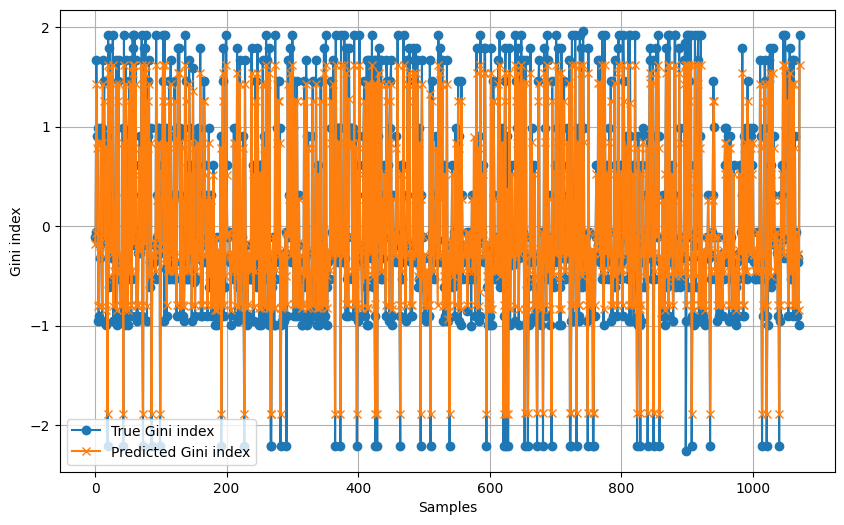

Comparison Table:
   GDP growth  Inflation  Gini index  Predicted GDP growth  \
0   -0.193032  -1.378780   -0.107174              0.396320   
1    0.979753   0.556737   -0.065007              0.836211   
2    0.256805   1.017266    1.663835              0.208151   
3    0.309472  -0.051843    0.904831              0.262356   
4    1.215608   0.093077    0.989165              1.031383   

   Predicted Inflation  Predicted Gini index  
0             0.144647             -0.179358  
1             0.383001             -0.067236  
2             0.858017              1.428733  
3            -0.066290              0.783050  
4             0.115081              0.833423  


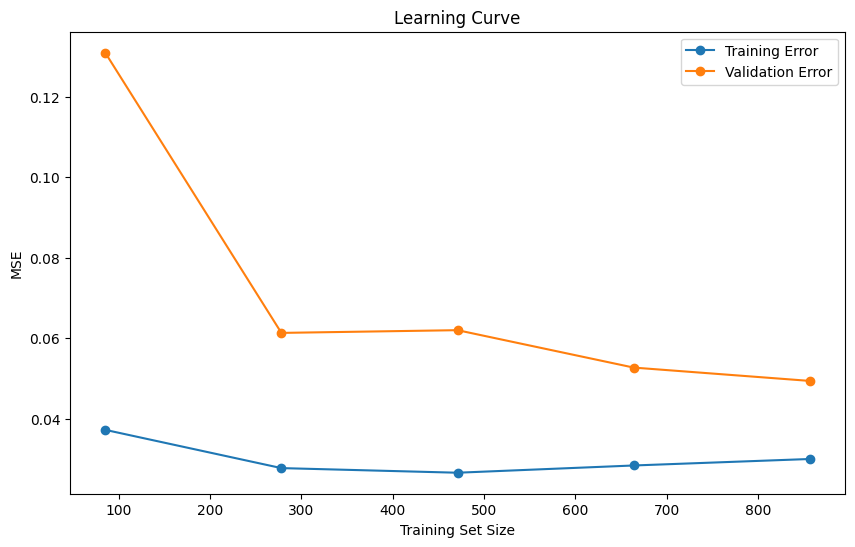

In [5]:
# # com Semente para Reprodutibilidade

import random
random.seed(42)
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# %% [markdown]
# # Importação de Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.utils import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
import tensorflow.keras.backend as K
import os
os.makedirs('graphs', exist_ok=True)
# %% [markdown]
# # Carregamento dos Dados e Separação das Variáveis

# Load the data
df = pd.read_csv('Processed_Normalized_Data.csv')

# Separate input and output variables
X = df.iloc[:, 1:-3]  # All budget expenditures (29 colunas)
y = df.iloc[:, -3:]   # GDP growth, Inflation, Gini index (3 colunas)

# %% [markdown]
# # Funções Auxiliares para Geração de Dados Sintéticos

def add_gaussian_noise(data, noise_scale=0.05):
    """
    Function to add Gaussian noise to data.
    """
    noise = np.random.normal(0, noise_scale, data.shape)
    return data + noise

def bootstrap_data(X, y, num_samples=1000):
    """
    Function to generate synthetic data using bootstrapping.
    """
    synthetic_X, synthetic_y = resample(X, y, n_samples=num_samples, random_state=42)
    return synthetic_X, synthetic_y

# %% [markdown]
# # Definição do VAE utilizando Subclassing

class VAE(Model):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder_h = Dense(64, activation='relu')
        self.z_mean = Dense(latent_dim)
        self.z_log_var = Dense(latent_dim)
        
        # Decoder
        self.decoder_h = Dense(64, activation='relu')
        self.decoder_mean = Dense(input_dim, activation='sigmoid')
    
    def encode(self, x):
        h = self.encoder_h(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def decode(self, z):
        h = self.decoder_h(z)
        return self.decoder_mean(h)
    
    def call(self, inputs):
        z_mean, z_log_var = self.encode(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)
        # Add KL divergence and reconstruction loss
        reconstruction_loss = K.sum(K.binary_crossentropy(inputs, reconstructed), axis=-1)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(reconstruction_loss + kl_loss))
        return reconstructed

# %% [markdown]
# # Geração de Dados Sintéticos Utilizando Múltiplos Métodos

def generate_synthetic_data(X, y, num_samples=1000):
    # Método 1: Adiciona ruído gaussiano
    noisy_X = add_gaussian_noise(X, noise_scale=0.05)
    noisy_y = add_gaussian_noise(y, noise_scale=0.05)
    # Preserve column names ao criar DataFrame
    noisy_X = pd.DataFrame(noisy_X, columns=X.columns)
    noisy_y = pd.DataFrame(noisy_y, columns=y.columns)
    
    # Método 2: Bootstrap data
    bootstrapped_X, bootstrapped_y = bootstrap_data(X, y, num_samples=num_samples)
    # As funções de resample já preservam os nomes das colunas se X e y são DataFrame
    
    # Método 3: Uso de VAE para gerar dados sintéticos
    input_dim = X.shape[1]
    latent_dim = 2
    vae = VAE(input_dim, latent_dim)
    vae.compile(optimizer='adam')
    vae.fit(X, X, epochs=50, batch_size=32, shuffle=True, verbose=0)
    vae_X = vae.predict(X)
    vae_y = y  # Usa os mesmos valores alvo ou gera novos
    # Preserve column names
    vae_X = pd.DataFrame(vae_X, columns=X.columns)
    vae_y = pd.DataFrame(vae_y, columns=y.columns)
    
    # Combina todos os dados sintéticos sem criar novas colunas
    synthetic_X = pd.concat([noisy_X, bootstrapped_X, vae_X], axis=0)
    synthetic_y = pd.concat([noisy_y, bootstrapped_y, vae_y], axis=0)
    
    return synthetic_X, synthetic_y

# Generate synthetic data
synthetic_X, synthetic_y = generate_synthetic_data(X, y, num_samples=1000)

# %% [markdown]
# # Combinação dos Dados Originais com os Sintéticos e Embaralhamento

X_augmented = pd.concat([X, synthetic_X], axis=0)
y_augmented = pd.concat([y, synthetic_y], axis=0)

# Shuffle the augmented dataset
augmented_data = pd.concat([X_augmented, y_augmented], axis=1)
augmented_data = augmented_data.sample(frac=1, random_state=42).reset_index(drop=True)
X_augmented = augmented_data.iloc[:, :-3]
y_augmented = augmented_data.iloc[:, -3:]

# Salva o conjunto aumentado em um arquivo CSV, se necessário
augmented_data.to_csv('augmented_dataset.csv', index=False)

# Dimensions of the data
n, p = X_augmented.shape

# %% [markdown]
# # Configuração do Modelo XGBoost para Regressão Multioutput e Validação Cruzada

kf = KFold(n_splits=5, shuffle=True, random_state=42)

general_mse_list = []
general_r2_list = []
general_adj_r2_list = []
train_scores, val_scores = [], []
detailed_metrics_list = []
y_true_all, y_pred_all = [], []

for train_index, test_index in kf.split(X_augmented):
    X_train, X_test = X_augmented.iloc[train_index], X_augmented.iloc[test_index]
    y_train, y_test = y_augmented.iloc[train_index], y_augmented.iloc[test_index]
    
    model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=980,
                         learning_rate=0.002,
                         random_state=42,
                         n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    general_mse = mean_squared_error(y_test, y_pred)
    general_rmse = np.sqrt(general_mse)
    general_r2 = r2_score(y_test, y_pred)
    general_sse = np.sum((y_test.values - y_pred) ** 2)
    general_adj_r2 = 1 - (1 - general_r2) * (n - 1) / (n - p - 1)
    
    general_mse_list.append(general_mse)
    general_r2_list.append(general_r2)
    general_adj_r2_list.append(general_adj_r2)
    
    train_scores.append(mean_squared_error(y_train, model.predict(X_train)))
    val_scores.append(general_mse)
    
    detailed_metrics = {}
    for i, column in enumerate(y_test.columns):
        mse = mean_squared_error(y_test[column], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test[column], y_pred[:, i])
        sse = np.sum((y_test[column].values - y_pred[:, i]) ** 2)
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        detailed_metrics[column] = {'MSE': mse,
                                    'RMSE': rmse,
                                    'R²': r2,
                                    'Adjusted R²': adj_r2,
                                    'SSE': sse}
    detailed_metrics_list.append(detailed_metrics)
    
    y_true_all.append(y_test.values)
    y_pred_all.append(y_pred)

# Mean metrics
general_mse_mean = np.mean(general_mse_list)
general_r2_mean = np.mean(general_r2_list)
general_adj_r2_mean = np.mean(general_adj_r2_list)

print("Consolidated Metrics:")
print(f"Mean General MSE: {general_mse_mean}")
print(f"Mean General R²: {general_r2_mean}")
print(f"Mean General Adjusted R²: {general_adj_r2_mean}")

# %% [markdown]
# # Cálculo das Métricas Detalhadas para Cada Variável

for variable in y.columns:
    mse_mean = np.mean([m[variable]['MSE'] for m in detailed_metrics_list])
    rmse_mean = np.mean([m[variable]['RMSE'] for m in detailed_metrics_list])
    r2_mean = np.mean([m[variable]['R²'] for m in detailed_metrics_list])
    adj_r2_mean = np.mean([m[variable]['Adjusted R²'] for m in detailed_metrics_list])
    print(f"--- {variable} Metrics ---")
    print(f"Mean MSE: {mse_mean}")
    print(f"Mean RMSE: {rmse_mean}")
    print(f"Mean R²: {r2_mean}")
    print(f"Mean Adjusted R²: {adj_r2_mean}")

# %% [markdown]
# # Comparação Visual entre Valores Reais e Preditos

labels = ['GDP growth', 'Inflation', 'Gini index']
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

def plot_comparison(y_true, y_pred, labels):
    for i, label in enumerate(labels):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true)), y_true[:, i], label=f'True {label}', marker='o')
        plt.plot(range(len(y_true)), y_pred[:, i], label=f'Predicted {label}', marker='x')
        plt.legend()
        plt.xlabel('Samples')
        plt.ylabel(label)
        plt.grid(True)
        plt.show()

plot_comparison(y_true_all, y_pred_all, labels)

# %% [markdown]
# # Comparação Tabular e Salvamento dos Resultados

comparison_df = pd.DataFrame(y_true_all, columns=labels)
comparison_df['Predicted GDP growth'] = y_pred_all[:, 0]
comparison_df['Predicted Inflation'] = y_pred_all[:, 1]
comparison_df['Predicted Gini index'] = y_pred_all[:, 2]
print("Comparison Table:")
print(comparison_df.head())
comparison_df.to_csv('comparison_table.csv', index=False)

# %% [markdown]
# # Curva de Aprendizado

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
    plt.plot(train_sizes, val_scores_mean, label='Validation Error', marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel('MSE')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Exemplo de plot da curva de aprendizado usando o modelo XGBoost treinado
plot_learning_curve(model, X_augmented, y_augmented, cv=5)

# Salvamento do Modelo e do conjunto de dados concatenados
joblib.dump(model, 'saved_model.pkl')

augmented_data.to_csv('augmented_dataset.csv', index=False)


def plot_and_save_comparison(y_true, y_pred, labels):
    for i, label in enumerate(labels):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true)), y_true[:, i], label=f'True {label}', marker='o')
        plt.plot(range(len(y_true)), y_pred[:, i], label=f'Predicted {label}', marker='x')
        plt.legend()
        plt.title(f'{label} - True vs Predicted')
        plt.xlabel('Samples')
        plt.ylabel(label)
        plt.grid(True)
        plt.savefig(f'graphs/{label.replace(" ", "_").lower()}_comparison.png')
        plt.close()

def plot_and_save_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
    plt.plot(train_sizes, val_scores_mean, label='Validation Error', marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel('MSE')
    plt.legend()
    plt.savefig('graphs/learning_curve.png')
    plt.close()

# Salva os gráficos de comparação e da curva de aprendizado
plot_and_save_comparison(y_true_all, y_pred_all, labels)
plot_and_save_learning_curve(model, X_augmented, y_augmented, cv=5)




In [6]:
import os
import matplotlib.pyplot as plt

# Assumes that X, synthetic_X, y, and synthetic_y are already defined

# Create the "graphs" folder if it does not exist
os.makedirs('graphs', exist_ok=True)

# =============================================================================
# Descriptive Statistics
# =============================================================================

# Input variables
stats_original_X = X.describe().loc[['mean', 'std', 'min', 'max']]
stats_synthetic_X = synthetic_X.describe().loc[['mean', 'std', 'min', 'max']]

# Output variables
stats_original_y = y.describe().loc[['mean', 'std', 'min', 'max']]
stats_synthetic_y = synthetic_y.describe().loc[['mean', 'std', 'min', 'max']]

# Print results
print("Statistics of original data (inputs):")
print(stats_original_X)
print("\nStatistics of synthetic data (inputs):")
print(stats_synthetic_X)

print("\nStatistics of original data (outputs):")
print(stats_original_y)
print("\nStatistics of synthetic data (outputs):")
print(stats_synthetic_y)

# Save results to CSV files
stats_original_X.to_csv("original_inputs_descriptive_stats.csv")
stats_synthetic_X.to_csv("synthetic_inputs_descriptive_stats.csv")
stats_original_y.to_csv("original_outputs_descriptive_stats.csv")
stats_synthetic_y.to_csv("synthetic_outputs_descriptive_stats.csv")

# =============================================================================
# Distribution Comparison with Boxplots and Histograms
# =============================================================================

# Boxplots for input variables
for col in X.columns:
    plt.figure(figsize=(8, 6))
    data = [X[col], synthetic_X[col]]
    plt.boxplot(data, labels=['Original', 'Synthetic'])
    plt.title(f'Distribution Comparison - {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.savefig(f'graphs/boxplot_{col}.png')
    plt.close()

# Boxplots for output variables
for col in y.columns:
    plt.figure(figsize=(8, 6))
    data = [y[col], synthetic_y[col]]
    plt.boxplot(data, labels=['Original', 'Synthetic'])
    plt.title(f'Distribution Comparison - {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.savefig(f'graphs/boxplot_{col}.png')
    plt.close()

# Histograms for input variables
for col in X.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(X[col], bins=20, alpha=0.5, label='Original')
    plt.hist(synthetic_X[col], bins=20, alpha=0.5, label='Synthetic')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Comparative Histogram - {col}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'graphs/histogram_{col}.png')
    plt.close()

# Histograms for output variables
for col in y.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(y[col], bins=20, alpha=0.5, label='Original')
    plt.hist(synthetic_y[col], bins=20, alpha=0.5, label='Synthetic')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Comparative Histogram - {col}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'graphs/histogram_{col}.png')
    plt.close()



Statistics of original data (inputs):
       Legislative     Judiciary  Essential to Justice  Administration  \
mean -1.110223e-16  1.665335e-16          2.220446e-16    2.868076e-16   
std   1.021508e+00  1.021508e+00          1.021508e+00    1.021508e+00   
min  -2.049252e+00 -1.463593e+00         -1.664928e+00   -1.486595e+00   
max   1.634838e+00  1.772988e+00          1.867415e+00    1.640225e+00   

      National Defense  Public Safety  Foreign Relations  Social Assistance  \
mean     -1.942890e-16  -1.110223e-16      -7.401487e-17       3.700743e-17   
std       1.021508e+00   1.021508e+00       1.021508e+00       1.021508e+00   
min      -1.071809e+00  -1.380108e+00      -1.534381e+00      -7.897149e-01   
max       1.678043e+00   2.172059e+00       1.679012e+00       3.560490e+00   

          Security        Health  ...   Agriculture  Agrarian Organization  \
mean -1.850372e-16 -7.401487e-17  ... -2.035409e-16          -2.220446e-16   
std   1.021508e+00  1.021508e+00  ...  

C:\Users\SAULO\AppData\Local\Temp\ipykernel_18768\3471329126.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Original', 'Synthetic'])
C:\Users\SAULO\AppData\Local\Temp\ipykernel_18768\3471329126.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Original', 'Synthetic'])
C:\Users\SAULO\AppData\Local\Temp\ipykernel_18768\3471329126.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Original', 'Synthetic'])
C:\Users\SAULO\AppData\Local\Temp\ipykernel_18768\3471329126.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of box

In [7]:
# Assuming that X, synthetic_X, y, and synthetic_y are already defined

# Initial number of observations
num_obs_original = X.shape[0]
num_obs_synthetic = synthetic_X.shape[0]

print("Number of original observations:", num_obs_original)
print("Number of synthetic observations:", num_obs_synthetic)

# Concatenation of original and synthetic data
X_augmented = pd.concat([X, synthetic_X], axis=0)
y_augmented = pd.concat([y, synthetic_y], axis=0)
augmented_data = pd.concat([X_augmented, y_augmented], axis=1)

# Final number of observations after concatenation
num_obs_final = augmented_data.shape[0]
print("Final number of observations after concatenation:", num_obs_final)

# Saving the final dataset to a CSV file (optional)
augmented_data.to_csv('augmented_dataset.csv', index=False)



Number of original observations: 24
Number of synthetic observations: 1048
Final number of observations after concatenation: 1072


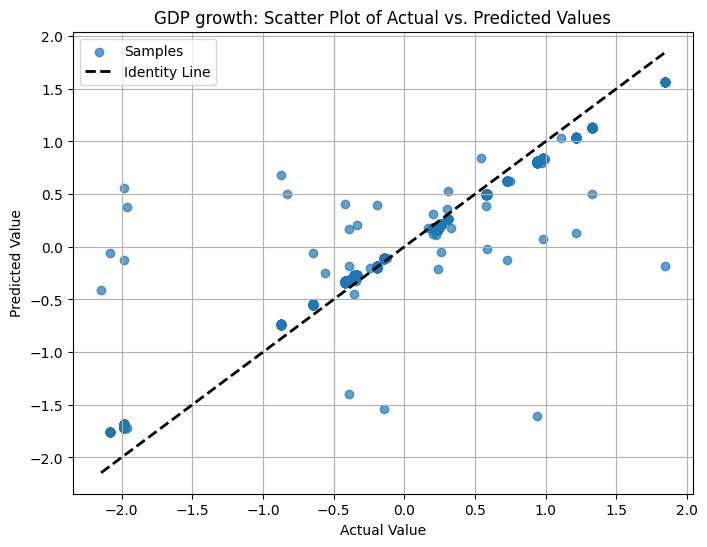

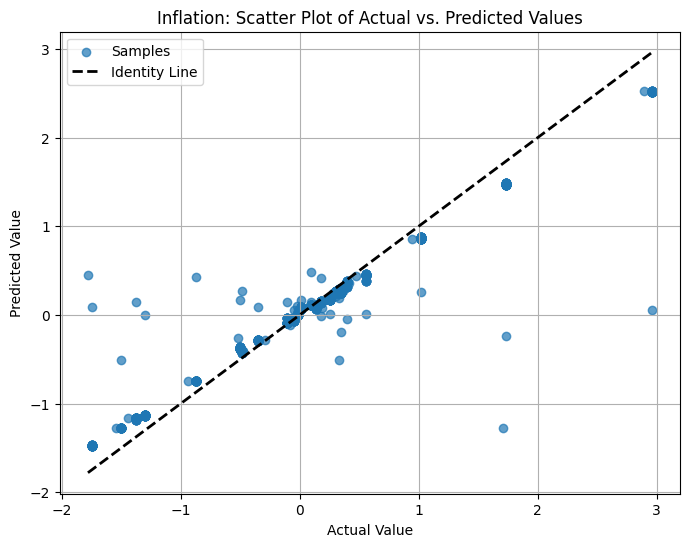

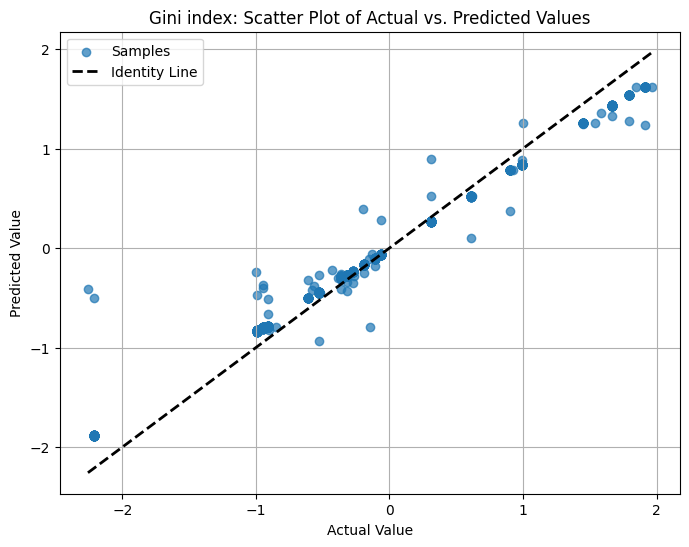

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create the "graphs" folder if it does not exist
os.makedirs('graphs', exist_ok=True)

def plot_scatter_comparison(y_true, y_pred, labels):
    """
    Generates scatter plots comparing actual and predicted values for each variable.
    
    Parameters:
        y_true (array): Actual values with shape (n_samples, n_variables).
        y_pred (array): Predicted values with shape (n_samples, n_variables).
        labels (list): Names of the variables.
    """
    for i, label in enumerate(labels):
        plt.figure(figsize=(8, 6))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.7, label='Samples')
        lim_inf = min(y_true[:, i].min(), y_pred[:, i].min())
        lim_sup = max(y_true[:, i].max(), y_pred[:, i].max())
        plt.plot([lim_inf, lim_sup], [lim_inf, lim_sup], 'k--', lw=2, label='Identity Line')
        plt.xlabel('Actual Value')
        plt.ylabel('Predicted Value')
        plt.title(f'{label}: Scatter Plot of Actual vs. Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'graphs/scatter_comparison_{label.replace(" ", "_").lower()}.png')
        plt.show()
        plt.close()

# Example usage:
# Assume y_true_all and y_pred_all are NumPy arrays with shape (n_samples, n_variables)
# and that labels is a list, for example:
# labels = ['GDP growth', 'Inflation', 'Gini index']
plot_scatter_comparison(y_true_all, y_pred_all, labels)

